# Implement probabilistic scores for ensemble forecasts
 
Now let's implement the ensemble scores. Please refer to the Dropbox document for their definition. 

1. Spread/Skill ratio: As mentioned in Scher and Messori (2020) there is a right way to do the order of the computations. Read their paragraph on it.
2. CRPS: Try the `properscoring` package. This one should be good.
3. Rank histogram: Try the `rankhistogram` package. No idea if this one is good. If it's ok but requires minor changes, we can consider a pull request. Otherwise, let's just write our own implementation. 

For all three scores:
- Use `xarray` as much as possible. Write a function similar to `src.score.compute_weighted_rmse.py`. 
- Ignore the weighted part at first.
- Create simple synthetic datasets to test extreme cases. E.g. `ensemble = [1, 1, 1]`, `obs=[1]` should result in a CRPS of 0. Think about what good sanity checks are for each score. For the rank histogram, for example, try to build examples that should end up in the shapes from the Dropbox document (overdispersion, underdispersion, etc.)
- Test the three functions with the "real" data from the dropout ensemble.
- Now the weighted part: Because the area of each lat-lon square is not the same but in fact varies with cos(lat), we want to weigh each grid point proportional to its area. This is already implemented for the rmse and acc scores in `src/score.py`. Implement this for the three probabilistic scores and compare to the unweighted scores. They shouldn't be too different. Implementing this for the rank histogram might require some thinking. We can talk about this together.

ToDo:
- make crps work for full data. try loading in batches.
- see rank histogram. maybe can make it faster.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *
import matplotlib.pyplot as plt

In [3]:
# # You only need this if you are using a GPU
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

In [4]:
# tf.compat.v1.disable_eager_execution() #needed
tf.__version__
!pwd

/home/garg/WeatherBench/nbs_probabilistic


In [5]:
exp_id_path='/home/garg/WeatherBench/nn_configs/B/82-resnet_d3_dr_0.2.yml'
model_save_dir='/home/garg/data/WeatherBench/predictions/saved_models'
datadir='/home/garg/data/WeatherBench/5.625deg'
pred_save_dir='/home/garg/data/WeatherBench/predictions'

In [6]:
start_date='2017-01-01'; end_date='2017-03-31'
start_date='2017-01-01'; end_date='2017-12-31'

In [7]:
exp_id_path='/home/garg/WeatherBench/nn_configs/B/82-resnet_d3_dr_0.2.yml'
!python create_dropout_ensemble.py 100 {exp_id_path} {datadir} {model_save_dir} {pred_save_dir} {start_date} {end_date}

DG start 10:21:04.237300
DG normalize 10:21:04.251525
DG load 10:21:04.256906
Loading data into RAM
DG done 10:21:12.153200
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2020-05-04 10:21:12.376316: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-04 10:21:12.380605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-04 10:21:12.381093: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:01:00.0
2020-05-04 10:21:12.381203: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-05-04 10:21:12.381865: I tensorflow/stream_executor/platform/default/

In [8]:
exp_id_path='/home/garg/WeatherBench/nn_configs/B/81-resnet_d3_dr_0.1.yml'
!python create_dropout_ensemble.py 100 {exp_id_path} {datadir} {model_save_dir} {pred_save_dir} {start_date} {end_date}

DG start 11:01:10.906396
DG normalize 11:01:10.920439
DG load 11:01:10.925811
Loading data into RAM
DG done 11:01:18.939729
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2020-05-04 11:01:19.169576: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-04 11:01:19.175698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-04 11:01:19.176190: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:01:00.0
2020-05-04 11:01:19.176408: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-05-04 11:01:19.179149: I tensorflow/stream_executor/platform/default/

In [9]:
exp_id_path='/home/garg/WeatherBench/nn_configs/B/80-resnet_d3_dr_0.05.yml'
!python create_dropout_ensemble.py 100 {exp_id_path} {datadir} {model_save_dir} {pred_save_dir} {start_date} {end_date}

DG start 11:41:31.632699
DG normalize 11:41:31.646757
DG load 11:41:31.652118
Loading data into RAM
DG done 11:41:39.539479
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2020-05-04 11:41:39.777220: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-04 11:41:39.783398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-04 11:41:39.783919: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:01:00.0
2020-05-04 11:41:39.784145: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-05-04 11:41:39.787153: I tensorflow/stream_executor/platform/default/

In [7]:
    exp_id_path='/home/garg/WeatherBench/nn_configs/B/81-resnet_d3_dr_0.1.yml'


    args=load_args(exp_id_path)
    exp_id=args['exp_id']
    var_dict=args['var_dict']
    batch_size=args['batch_size']
    output_vars=args['output_vars']
    
    #Question: how to optionally  input data_subsample, norm_subsample, nt_in, dt_in, test_years?
    data_subsample=args['data_subsample']
    norm_subsample=args['norm_subsample']
    nt_in=args['nt_in']
    dt_in=args['dt_in']
    test_years=args['test_years']
    lead_time=args['lead_time']
    

In [8]:
preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

In [9]:
preds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 20, time: 1042)
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * time     (time) datetime64[ns] 2017-01-04T04:00:00 ... 2017-03-31T22:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (member, time, lat, lon) float64 ...
    t_850    (member, time, lat, lon) float64 ...

In [10]:
z500_valid = load_test_data(f'{datadir}/geopotential_500', 'z')
t850_valid = load_test_data(f'{datadir}/temperature_850', 't')

In [11]:
observation=xr.Dataset()
observation['z_500']=z500_valid
observation['t_850']=t850_valid

In [12]:
observation=observation.astype('float64')
observation=observation.drop('level')

In [14]:
# observation=observation.sel(time=preds.time)
# assert (observation.time==preds.time).all

In [13]:
observation

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Data variables:
    z_500    (time, lat, lon) float64 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    t_850    (time, lat, lon) float64 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>

In [14]:
observation.t_850.values[0:3,0,0] #unnormalized already

array([257.84133911, 257.58569336, 257.3553772 ])

In [15]:
tigge_dir='/home/garg/data/WeatherBench/tigge/5.625deg'
tigge_var_list=['geopotential_500_ens','temperature_850_ens']
#tigge_var_list=['temperature_850_ens']

tigge=xr.merge([xr.open_mfdataset(f'{tigge_dir}/{var}/*.nc'
                        , combine='by_coords') for var in tigge_var_list], compat="override")
#compat=override is dangerous. Any other way? the first coordinate: isobaricInhPa is different for both

tigge=xr.Dataset.rename(tigge,{'number':'member','gh':'z_500','t':'t_850'})

tigge=tigge.drop({'isobaricInhPa','valid_time'}) 

#What does step mean?
tigge['z_500']=tigge['z_500'].sel(step='3 days').drop('step')
tigge['t_850']=tigge['t_850'].sel(step='3 days').drop('step')

tigge=tigge.drop('step')

tigge

,Array,Chunk
Bytes,598.02 MB,25.40 MB
Shape,"(50, 1460, 32, 64)","(50, 62, 32, 64)"
Count,96 Tasks,24 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,598.02 MB,25.40 MB
Shape,"(50, 1460, 32, 64)","(50, 62, 32, 64)"
Count,96 Tasks,24 Chunks
Type,float32,numpy.ndarray


In [16]:
tigge.z_500.values.shape

(50, 1460, 32, 64)

In [17]:
tigge.t_850.values[0,0:5,0,0], tigge.z_500.values[0,0:5,0,0] #magnitude of z is wrong.

(array([258.87042, 257.26797, 259.67017, 259.9244 , 258.9179 ],
       dtype=float32),
 array([5237.1724, 5237.684 , 5228.717 , 5185.7466, 5157.6587],
       dtype=float32))

In [18]:
g=float(9.806) #gravity
tigge['z_500']=tigge.z_500*g

In [19]:
tigge.t_850.values[0,0:5,0,0], tigge.z_500.values[0,0:5,0,0] #

(array([258.87042, 257.26797, 259.67017, 259.9244 , 258.9179 ],
       dtype=float32),
 array([51355.71 , 51360.73 , 51272.797, 50851.43 , 50576.   ],
       dtype=float32))

# Evaluation methods: Spread-skill, CRPS, Rank histogram
check src/score.py.

In [ ]:
#Issues
#Spread-skill: 
#Ensure equal size of observation, tigge and preds.
    #Spread should be also only be counted on same 'time' as for preds, for fair comparison?
#tigge data for z_500 is 1 magnitude smaller. 
#skill value worse than preds.

#CRPS :
#Ensure equal size of observation, tigge and preds.
#is sometimes unable to run on whole data at once. need to batch.
#if ran twice, throws error: 'Dataset' object is not callable.
#manually need to re-import modules.(Codecell 2)


#Rank histogram: 
#Ensure equal size of observation, tigge and preds.
#takes too much time.

In [20]:
##Ensure equal size of observation, tigge and preds. Better way?
obs2=observation.sel(time=preds.time) #for preds
obs3=observation.sel(time=tigge.time)
tigge_small=tigge.sel(member=slice(0,20)) #same as preds. (for now!)

In [53]:
#Spread-skill for PREDS
#Method 1: Evaluating Spread-Skill Ratio (Based on Paper by scher and Messori 2020: Ensemble NN forecasts with SVD)
mean_spread=compute_weighted_meanspread(preds); print(mean_spread)
ensemblemean=preds.mean('member')
mean_rmse=compute_weighted_rmse(observation,ensemblemean).load(); print(mean_rmse)

#spread_skill_ratio=mean_spread/mean_rmse; print(spread_skill_ratio)
spread_skill_ratio_z500=mean_spread.z_500_mean_spread/mean_rmse.z_500_rmse
spread_skill_ratio_t850=mean_spread.t_850_mean_spread/mean_rmse.t_850_rmse
print(spread_skill_ratio_z500)
print(spread_skill_ratio_t850) 
#CouldDo: make a single Dataset by keeping same name as z500, t850
#So spread is low compared to RMSE. That means a over confident prediction?

<xarray.Dataset>
Dimensions:            ()
Data variables:
    z_500_mean_spread  float64 129.5
    t_850_mean_spread  float64 0.6338
<xarray.Dataset>
Dimensions:     ()
Data variables:
    z_500_rmse  float64 330.0
    t_850_rmse  float64 1.865
<xarray.DataArray ()>
array(0.39244767)
<xarray.DataArray ()>
array(0.33992577)


In [54]:
#Spread-Skill for TIGGE. 
#Method 1: Evaluating Spread-Skill Ratio (Based on Paper by scher and Messori 2020: Ensemble NN forecasts with SVD)
mean_spread=compute_weighted_meanspread(tigge).load(); print(mean_spread)
ensemblemean=tigge.mean('member')
mean_rmse=compute_weighted_rmse(observation,ensemblemean).load(); print(mean_rmse)

spread_skill_ratio_z500=mean_spread.z_500_mean_spread/mean_rmse.z_500_rmse
spread_skill_ratio_t850=mean_spread.t_850_mean_spread/mean_rmse.t_850_rmse
print(spread_skill_ratio_z500)
print(spread_skill_ratio_t850) #tigge should be better, at least in rmse. but is not?

<xarray.Dataset>
Dimensions:            ()
Data variables:
    z_500_mean_spread  float64 152.1
    t_850_mean_spread  float64 1.116
<xarray.Dataset>
Dimensions:     ()
Data variables:
    z_500_rmse  float64 925.8
    t_850_rmse  float64 4.169
<xarray.DataArray ()>
array(0.16428602)
<xarray.DataArray ()>
array(0.26759205)


In [57]:
print(tigge.t_850.values[0:3,0,0,0])
print(obs3.t_850.values[0:3,0,0])

print(tigge.z_500.values[0:3,0,0,0])
print(obs3.z_500.values[0:3,0,0]) 

[258.87042 259.60455 258.81906]
[257.84133911 257.22409058 257.40374756]
[51355.71  51546.69  51384.426]
[50954.625    50939.3125   51000.578125]


In [60]:
#Spread-Skill for TIGGE_SMALL.
#Method 1: Evaluating Spread-Skill Ratio (Based on Paper by scher and Messori 2020: Ensemble NN forecasts with SVD)
mean_spread=compute_weighted_meanspread(tigge_small).load(); print(mean_spread)
ensemblemean=tigge_small.mean('member')
mean_rmse=compute_weighted_rmse(obs3,ensemblemean).load(); print(mean_rmse)

spread_skill_ratio_z500=mean_spread.z_500_mean_spread/mean_rmse.z_500_rmse
spread_skill_ratio_t850=mean_spread.t_850_mean_spread/mean_rmse.t_850_rmse
print(spread_skill_ratio_z500)
print(spread_skill_ratio_t850) #not much difference betweeen 20 ens and 50 ens of tigge, i'd say.

<xarray.Dataset>
Dimensions:            ()
Data variables:
    z_500_mean_spread  float64 151.1
    t_850_mean_spread  float64 1.103
<xarray.Dataset>
Dimensions:     ()
Data variables:
    z_500_rmse  float64 926.0
    t_850_rmse  float64 4.172
<xarray.DataArray ()>
array(0.16318484)
<xarray.DataArray ()>
array(0.26438545)


# Method 2: CRPS

In [61]:
#Method 2: Continuous Ranked Probablity Score (properscoring package)
from src.score import * #ToDo: Need to re-load everytime.
member_axis=xr.DataArray.get_axis_num(preds.z_500,'member')
crps_score=crps_score(preds, observation,member_axis); print(crps_score)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 171.8
    t850     float64 1.076


In [62]:
# from src.score import *
# member_axis=xr.DataArray.get_axis_num(preds.z_500,'member')
# crps_score=crps_score(preds, obs2,member_axis); print(crps_score)
# #Works without reducing observation size. since condition added in crps function. check score.py

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 171.8
    t850     float64 1.076


In [63]:
#FOR TIGGE. full data. throws space error.
from src.score import *
member_axis=xr.DataArray.get_axis_num(tigge.z_500,'member')
crps_score=crps_score(tigge, obs3,member_axis).load(); print(crps_score)

MemoryError: Unable to allocate 55.7 GiB for an array with shape (2, 1460, 32, 64, 50, 50) and data type float32

In [21]:
#FOR TIGGE_small. Sometimes runs, sometimes fails
from src.score import *
member_axis=xr.DataArray.get_axis_num(tigge_small.z_500,'member')
crps_score=crps_score(tigge_small, obs3,member_axis).load(); print(crps_score)
#Why would score be worse for t850?

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 512.4
    t850     float64 2.424


In [65]:
#sanity check. MAE=crps for 1 ensemble member
from src.score import *
obs_single=observation
pred_single=preds.isel(member=0)

#mean absolute error
mae=compute_weighted_mae(pred_single,obs_single).load(); print(mae)
#crps for single
crps_score_single=crps_score(pred_single,obs_single,member_axis); print(crps_score_single)

<xarray.Dataset>
Dimensions:    ()
Coordinates:
    member     int64 0
Data variables:
    z_500_mae  float64 229.2
    t_850_mae  float64 1.376
<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 229.2
    t850     float64 1.376


In [66]:
#Sanity Check for TIGGE
from src.score import *
obs_single=observation
pred_single=tigge.isel(member=0)

#mean absolute error
mae=compute_weighted_mae(pred_single,obs_single).load(); print(mae)
#crps for single
crps_score_single=crps_score(pred_single,obs_single,member_axis); print(crps_score_single)

<xarray.Dataset>
Dimensions:    ()
Coordinates:
    member     int64 1
Data variables:
    z_500_mae  float64 573.6
    t_850_mae  float64 2.943
<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 573.6
    t850     float64 2.943


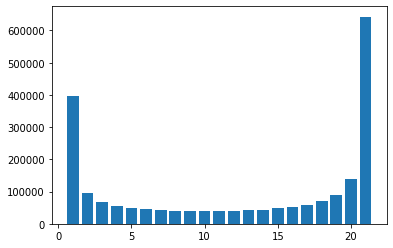

In [22]:
#Method 3: Rank Histogram
# !pip install rank-histogram
# R code: https://rdrr.io/cran/SpecsVerification/src/R/Rankhist.R
from ranky import rankz

#obs = np.asarray(observation.to_array(), dtype=np.float32).squeeze(); #Full data. #DOES NOT WORK if dimensions dont match
obs = np.asarray(obs2.to_array(), dtype=np.float32).squeeze();#small data

obs_z500=obs[0,...].squeeze()
obs_t850=obs[1,...].squeeze()

pred=np.asarray(preds.to_array(), dtype=np.float32).squeeze();
pred_z500=pred[0,...].squeeze() 
pred_t850=pred[1,...].squeeze() 

mask=np.ones(obs_z500.shape) #useless. #masked where 0/false.
# feed into rankz function
result = rankz(obs_z500, pred_z500, mask)
# plot histogram
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
# view histogram
plt.show() ##overconfident (underdispersive)

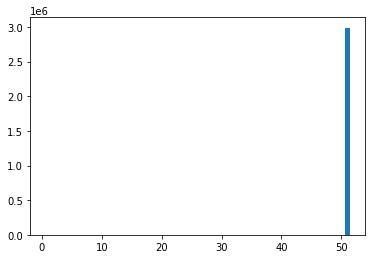

In [90]:
#FOr TIGGE. SLOW!! (OLD)
#Method 3: Rank Histogram
# !pip install rank-histogram
# R code: https://rdrr.io/cran/SpecsVerification/src/R/Rankhist.R
from ranky import rankz

obs = np.asarray(obs3.to_array(), dtype=np.float32).squeeze();
obs_z500=obs[0,...].squeeze()
obs_t850=obs[1,...].squeeze()

pred=np.asarray(tigge.to_array(), dtype=np.float32).squeeze();
pred_z500=pred[0,...].squeeze() 
pred_t850=pred[1,...].squeeze() 

mask=np.ones(obs_z500.shape) #useless. #masked where 0/false.
# feed into rankz function
result = rankz(obs_z500, pred_z500, mask)
# plot histogram
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
# view histogram
plt.show() ##overconfident (underdispersive)

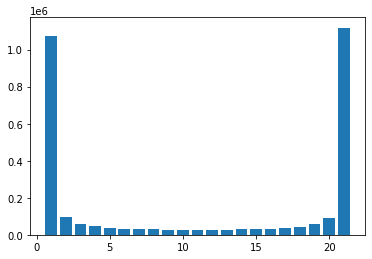

In [23]:
#FOr TIGGE_small
#Method 3: Rank Histogram
# !pip install rank-histogram
# R code: https://rdrr.io/cran/SpecsVerification/src/R/Rankhist.R
from ranky import rankz

obs = np.asarray(obs3.to_array(), dtype=np.float32).squeeze();
obs_z500=obs[0,...].squeeze()
obs_t850=obs[1,...].squeeze()

pred=np.asarray(tigge_small.to_array(), dtype=np.float32).squeeze();
pred_z500=pred[0,...].squeeze() 
pred_t850=pred[1,...].squeeze() 

mask=np.ones(obs_z500.shape) #useless. #masked where 0/false.
# feed into rankz function
result = rankz(obs_z500, pred_z500, mask)
# plot histogram
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
# view histogram
plt.show() ##overconfident (underdispersive). looks worse than our preds.!

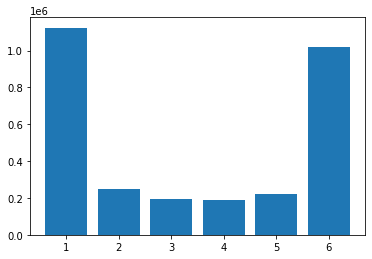

In [96]:
#For Temperature. Should be better. (OLD)
result = rankz(obs_t850, pred_t850, mask)
# plot histogram
plt.bar(range(1,pred_t850.shape[0]+2), result[0])
# view histogram
plt.show() ##overconfident (underdispersive)

In [ ]:
#old code. ignore.

In [ ]:
#result from old code with 50 forecasts. just to show it is still overconfident
result = rankz(obs_t850, pred_t850, mask)
plt.bar(range(1,pred_t850.shape[0]+2), result[0])
plt.show()

In [ ]:
#sanity check: for a random sample
obs = np.random.randn(10, 40, 40)
ensemble = np.random.randn(20, 10, 40, 40)
mask = np.random.randint(0, 2, (10, 40, 40)) #masked where 0/false.
# feed into rankz function
result = rankz(obs, ensemble, mask)
# plot histogram
plt.bar(range(1,ensemble.shape[0]+2), result[0])
# view histogram
plt.show()

In [ ]:
#testing for smaller number of bins (i.e. forecasts) (For old predictions.)
obs_small=obs_z500[:,:,:].squeeze()
pred_small=pred_z500[0:10,:,:,:]
mask=np.ones(obs_small.shape).squeeze()
print(obs_small.shape)
print(pred_small.shape)
print(mask.shape)

result = rankz(obs_small, pred_small, mask)
plt.bar(range(1,pred_small.shape[0]+2), result[0])
plt.show() #overconfident (underdispersive)